<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_85_15_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 트랜스포머 소개

## 언어 번역 예제 소개 (포르투칼 어를 영어로)
- 참고자료: ["Attention is all you need(2017)"](https://arxiv.org/abs/1706.03762)
- self attention을 사용하여 CNN 또는 RNN을 대체한 딥러닝 모델
- 입력 시퀀스 간의 정보 전달을 잘 수행한다

## 언어 번역 신경망 모델
- 기존의 RNN 기반의 seq2seq 모델에서 RNN을 셀프 어텐션으로 바꾼 구조를 갖는다
- 인코더는 입력(언어 시퀀스)을 받아 입력의 의미를 수치들의 벡터로 표현하며, 디코더는 번역된 언어를 출력한다
- 셀프 어텐션을 사용하면, 각 단어는 입력 전체 단어(토큰)들과의 관계정보를 모두 가중 취합하여 컨텍스트에 맞는 의미를 얻게 되며 이 작업을 모든 단어에 대해 병렬적으로 처리함으로써 정확도를 높이고 다수의 계층을 통과하면서 더 추상적인 (복잡한) 단어간의 관계를 더 정확하게 파악할 수 있게 된다

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: 머신 번역에 트랜스포머를 사용하는 예 [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


## 예제에서 소개할 내용

- 데이터 준비
- 필요한 기능 구현:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- 모델 학습
- 모델 수행
- 모델 확용

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

- 이 모델을 학습하면 포르투칼어를 입력하면 영어 문장을 얻는 모델을 얻게 된다

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: 여러 멀티헤드에서 얻는 attention weights.

## 트랜프포머의 특징

- Transformers excel at modeling sequential data, such as natural language.
- RNN과 달리 병렬처리가 가능하여 속도 개선이 용이하다
- RNN 또는 CNN과 달리 입력 및 출력 시퀀스에 멀리 떨어져 있는 데이터간의 컨텍스트 정보를 잡아낼 수 있다
- 데이터 간의 시간적/공간적인 어떤 가정도 필요하지 않다 (복수의 객체를 다룰 때 유리하다)

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: 단어 it에 대한 계층 5와 6에서의 self-attention distribution [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

# 환경 설정

- 데이터셋을 얻기 위해서 [TensorFlow Datasets](https://tensorflow.org/datasets)을 설치하고 텍스트 전처리를 위해서 [TensorFlow Text](https://www.tensorflow.org/text)를 설치한다

In [1]:
# 최신 버전을 재설치한다
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 2 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 21s (20.7 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to

# Import

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## 데이터

- 데이터셋과 토크나이저(subword tokenizer)를 다운로드한다. 참고:[this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer)
- `tf.data.Dataset`에 저장한다



### Download the dataset

- 다운로드 데이터 [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)
- 52,000개의 훈련데이터, 1,200 개의 검증 데이터, 1,800 개의 테스트 데이터 제공

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete5HL38B/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete5HL38B/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete5HL38B/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


- 데이터셋 `tf.data.Dataset`는 쌍으로 된 문장들을 생성한다(yields)

In [4]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


# 토크나이저

- 토큰은 문장을 분석하는 단위 정보인데, sentence-pieces, words, subwords, characters 단위가 가능하다
- 참고 [this guide](https://www.tensorflow.org/text/guide/tokenizers).

- 여기서는 [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer)를 사용한다(`text.BertTokenizer`)
- `saved_model` 포맷으로 제공된다.

In [5]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 1s 4us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [6]:
tokenizers = tf.saved_model.load(model_name)

- `tf.saved_model`에는 영어와 포르투칼어를 위한 두가지 토크나이저가 들어있다.

In [7]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

- `tokenize` 함수는 배치단위로 문자열을 token ID의 배열로 바꾸어준다.

In [8]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [9]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


- `detokenize`는 토큰화의 반대 작업을 수행한다

In [10]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


- `lookup` 함수는 token-ID 를 토큰 텍스트로 바꾸어준다


In [11]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

- 서브워드 토큰을 확인할 수 있다
- 예를 들면: `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.
- 시작과 종료 토큰이 있다 `'[START]'` and `'[END]'` tokens.

- 각 샘플별 토큰의 수 분포는 아래와 같다

In [12]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

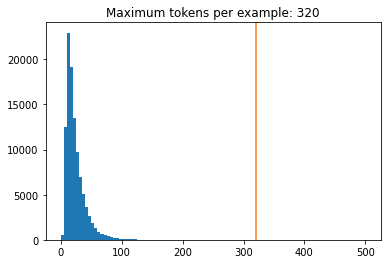

In [13]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

## `tf.data` 처리 절차

- 아래의 작업은 배치 단위로 이루어진다

1. ragged batch로 토큰화 한다
2. 최대 길이를`MAX_TOKENS`로 자른다
3. 목적 값인 영어에 대해서는 inputs과 labels를 한 유닛 차이나는 값으로 지정한다
4. 텐서 형식으로 저장한다
5. `(inputs, labels)` 값을 리턴한다


In [14]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

- 훈련 데이터셋을 배치 단위로 다음과 같이 나눈다

1. 토큰화를 수행하고 길이가 긴 시퀀스는 자른다 (배치 크기가 크면 토큰화가 더 호율적이다)
2. `cache` 한수는 실행을 단 한번만 수행하게 한다
3. `shuffle`과`dense_to_ragged_batch`는 샘플의 배치 순서를 랜덤하게 정한다
4. `prefetch`는 데이터를 미리준비하게 한다

In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [16]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

# 데이터셋 검증

In [17]:
# 훈련과 검증 데이터셋 배치 만들기
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

- `tf.data.Dataset` 객체는 케라스의 `Model.fit`을 사용하는데 입력으로 `(inputs, labels)` 쌍을 받는다
- `inputs` 은 토큰화된 포루투칼, 영어 문장 쌍이다. `(pt, en)`.
- `labels`은 입력과 같은 영문이며 한 스텝 지연된 시퀀스이다

<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

- 영어 입력 -> 영어 출력의 [text generation tutorial](text_generation.ipynb) 모델과 같으나 포루투칼 어를 추가 컨텍스트(즉, 모델의 추가 조건)로 입력하는 셈이다

- 현재의 셋업을 "teacher forcing"이라고 하는데, 모델의 출력이 무엇이든, 다음 스텝에서 정답을 입력으로 받는 것을 말한다. 텍스트 생성 모델에서 흔히 사용하는 방법이다

- 이 방법은 모델을 순차적으로 실행시키지 않아도 되며 다른 시퀀스 위치의 연산은 병렬처리가 가능하다

- 입력으로 포루투칼어, 출력으로 영어를 사용하는 (예전의) 시퀀스-시퀀스 모델은, 순차적이 학습만 가능하므로 속도가 느리다. 오류를 수정한 기회가 있는 장점은 있다.

In [18]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 83)
(64, 64)
(64, 64)


The `en` and `en_labels` are the same, just shifted by 1:

In [19]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   96   80  200  778   74 3438 3719 2980   15], shape=(10,), dtype=int64)
tf.Tensor([  96   80  200  778   74 3438 3719 2980   15    3], shape=(10,), dtype=int64)


## 내용 구현

- 기본적으로 sequence-to-sequence 모델로 구현된다
- 전체 개념도는 아래와 같다

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>


### The embedding and positional encoding layer

- 인코더와 디코더의 입력은 모두 동일한 임베딩과 positional encoding을 사용한다.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

- 토큰들의 시퀀스에 대해 입력(포루투칼)과 타겟(영어) 모두 벡터로 변환된다: `tf.keras.layers.Embedding` 계층 사용

- 어텐션 계층은 (순서없는, BoW 처럼) 다수의 벡터만 입력으로 받으므로 단어들의 순서 정보를 추가고 줄 필요가 있다 (RNN이나 CNN에서는 순서 정보를 사용하고 있다)

- 이를 위해서 임베딩 벡터에 "Positional Encoding"을 추가한다
- 사인과 코사인을 사용해서 토큰사이의 거리를 반영한다

- positional encoding 계산식:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [20]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

- PE는 위치에 따라서 서로 다른 주파수로 진동하는 사인과 코사인파의 합으로 표시된다

(2048, 512)


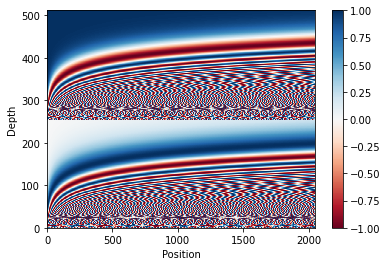

In [21]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

- 이러한 PE를 사용함으로써 위치를 구분할 수 있다. 위치 1000에서의 PE과 모든 위치 정보와의 dot-product 계산하면 아래와 같이 1000의 위치값만 크게 나타난다

(0.0, 1.0)

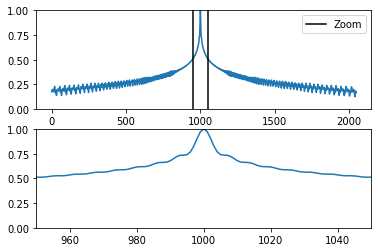

In [22]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


- 이렇게 구한 PE을 임베딩 벡터와 합해서 사용한다

In [23]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [24]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [25]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 64), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

- "Add & Norm" 블록은 각 계층마다 수행하는데 residual connection을 더하고 계층정규화`LayerNormalization` 를 수행한다 

- 이는 학습을 효율적으로 수행하기 위한 작업이다
- Residual connection: 어텐션 계층에 의해 새로운 값을 새로 계산하는 것이 아니라(replaced), 업데이트하는 효과를 얻는다.



### The base attention layer

- 기본 어텐션 계층은 반복적으로 사용된다 `layers.MultiHeadAttention`과 `layers.LayerNormalization` 그리고 `layers.Add`를 사용한다

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

In [26]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add() # 케라스 mask의 propagate는 Add()로 수행

### Attention 동작 개요

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

- 입력이 두가지 이다

1. query sequence; 처리될 시퀀스로 어텐드를 수행한다 - 아래
2. context sequence; 어텐드를 받는 시퀀스 (K, V) - 좌측

- 출력은 query-sequence와 같은 모양을 갖는다

- 이는 사전을 찾는 작업과 유사하다
 - A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

- 아래와 같은 사전에서,

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

- 일반적인 (프로그램에서의) 사전이라면 명확한 키가 하나 존재하겠지만 여기서는 **fuzzy** 한 사전을 가정하는 것이며 완벽히 일치하는 하나의 키가 있는 것은 아니라고 가정한다

- 예를 들어 `d["species"]`를 찾는 것이었다면 가장 가까운 `"pickup"`를 찾아내야 할 것이다.

- 어텐션은 이와 같이 fuzzy한 검색을 하는 것이며 베스트 키를 하나만 찾는 것이 아니라 원하는 query를 잘 반영하는 (match) 다수의 키들을 찾아내고 이의 가중치로 해당하는 값들을 재구성(combine)하는 것이다

- 어텐션 계층에서는 `query`, `key`, `value`가 이러한 작업을 수행한다. 즉, `query`와 `key` 들이 얼마나 잘 매치하는 지를 계산하는데 이를 "attention score"라고 한다.
- 어텐션 계층이 출력은 각 `values`의 가중합으로 구하며 이때 가중치로 "attention scores"를 사용한다

- 각 위치에 대해서 query-sequence로부터 `query` 벡터가 제공되고, context sequence는 마치 사전처럼 동작한다 context sequence의 각 위치에 대해서 `key`와`value` 벡터가 계산된다.

- 입력 벡터를 출력을 얻는데 직접 바로 사용하는 것이 아니다. 
- `layers.MultiHeadAttention` 계층에 전결합망이 포함되어 있다


### The cross attention layer

- 이는 인코더와 디코더를 연결하는 계층이다
- 참조: [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

- 이를 구현하기 위해서 mha() 호출시에 target sequence `x`를 `query`로 사용하고 `context` sequence를 `key/value`로 사용한다

In [27]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

- 아래는 이 계층의 정보흐름을 보였는데 각 컬럼은 context sequence에 대한 가중합을 나타낸다

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

- 아래는 좀 더 단순화한 개념도인데, 출력의 길이는 `query`의 길이와 같다 (context인 `key/value` 길이가 아니라)

- 이 그림에서 강조하는 것은 각 `query` 위치에서는 모든 `key/value` 값을 볼 수 있으나, query 들 사이의 정보 교류는 없다는 것이다.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

- 샘플 입력에 대해 테스트 수행

In [28]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 83, 512)
(64, 64, 512)
(64, 64, 512)


### The global self attention layer

- context sequence를 처리하고 정보를 상위로 전달한다

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

- 번역이 수행되는 동안 context는 고정되어 있으므로 정보는 양방향으로 흐를 수 있도록 허용된다

- 트랜스포머 도입 전에는 RNN이나 CNN으로 이 작업을 구현했다

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

- RNN과 CNN의 한계

- RNN에서는 시퀀스 전체에 정보가 전달될 수는 있으나, 각 스텝을 거쳐야 한다. 또한 순차적으로 계산을 해야 하므로 병렬처리를 할 수 없다
- CNN에서는 위치에 대해서 병렬 처리를 할 수 있다. 그러나 수용필드의 크기가 제한된다. 수용 필드를 키우려면 계층을 여러번 통과해야 한다
- [Wavenet](https://arxiv.org/abs/1609.03499)을 사용하면 dilated convolutions으로 이 문제를 완화할 수 있다

- 트랜스포머의 global self attention layer는 각 시퀀스 항목에서 모든 다른 항목을 직접, 빠르게 액세스할 수 있고, 병렬처리도 가능하다
- 이 계층에서는 target sequence `x`를 mha() 함수의 `query`, `key`, `value`로 사용하면 된다

In [29]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [30]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 83, 512)
(64, 83, 512)


- 이 계층의 개념도는 아래와 같다

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [31]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [32]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 64, 512)
(64, 64, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [33]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [34]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [35]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 64, 512)
(64, 64, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [37]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 83, 512)
(64, 83, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [39]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 83)
(64, 83, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [41]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 64, 512)
(64, 83, 512)
(64, 64, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [43]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 64)
(64, 83, 512)
(64, 64, 512)


In [44]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 64, 83])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

In [45]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [46]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [47]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [48]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 64)
(64, 83)
(64, 64, 7010)


In [49]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 64, 83)


Print the summary of the model:

In [50]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [51]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [52]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

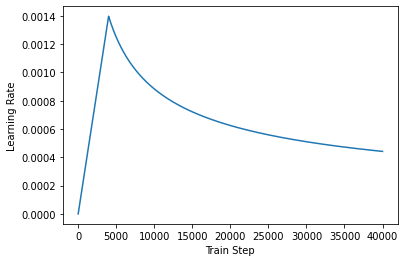

In [53]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [54]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [55]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [56]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 211s 247ms/step - loss: 6.5921 - masked_accuracy: 0.1376 - val_loss: 5.0356 - val_masked_accuracy: 0.2479
Epoch 2/20
810/810 [==============================] - 200s 247ms/step - loss: 4.5736 - masked_accuracy: 0.2974 - val_loss: 4.0577 - val_masked_accuracy: 0.3563
Epoch 3/20
810/810 [==============================] - 200s 246ms/step - loss: 3.8271 - masked_accuracy: 0.3798 - val_loss: 3.4644 - val_masked_accuracy: 0.4318
Epoch 4/20
810/810 [==============================] - 200s 247ms/step - loss: 3.3046 - masked_accuracy: 0.4358 - val_loss: 3.0231 - val_masked_accuracy: 0.4828
Epoch 5/20
810/810 [==============================] - 197s 243ms/step - loss: 2.8986 - masked_accuracy: 0.4818 - val_loss: 2.7341 - val_masked_accuracy: 0.5192
Epoch 6/20
810/810 [==============================] - 198s 244ms/step - loss: 2.5764 - masked_accuracy: 0.5212 - val_loss: 2.4918 - val_masked_accuracy: 0.5585
Epoch 7/20
810/810 [====================

## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [57]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [58]:
translator = Translator(tokenizers, transformer)

In [59]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [60]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [61]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [62]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to be very quickly to share with you some of some magic things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [63]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [64]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [65]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [66]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [67]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

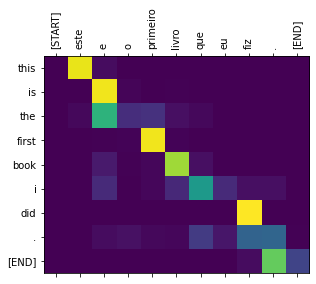

In [68]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [69]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

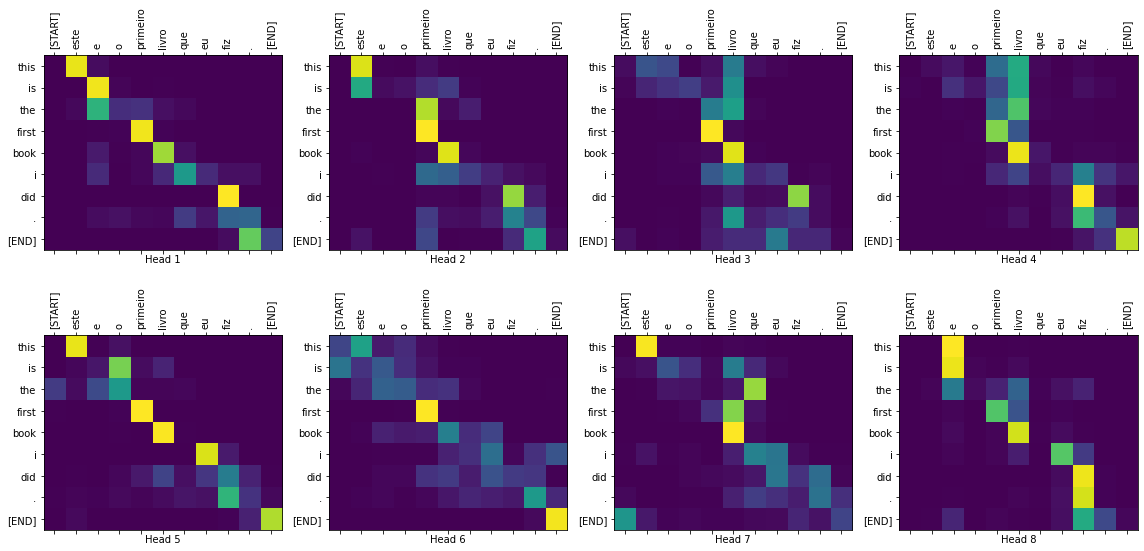

In [70]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triopsychos in the enclota .
Ground truth   : I read about triceratops in the encyclopedia.


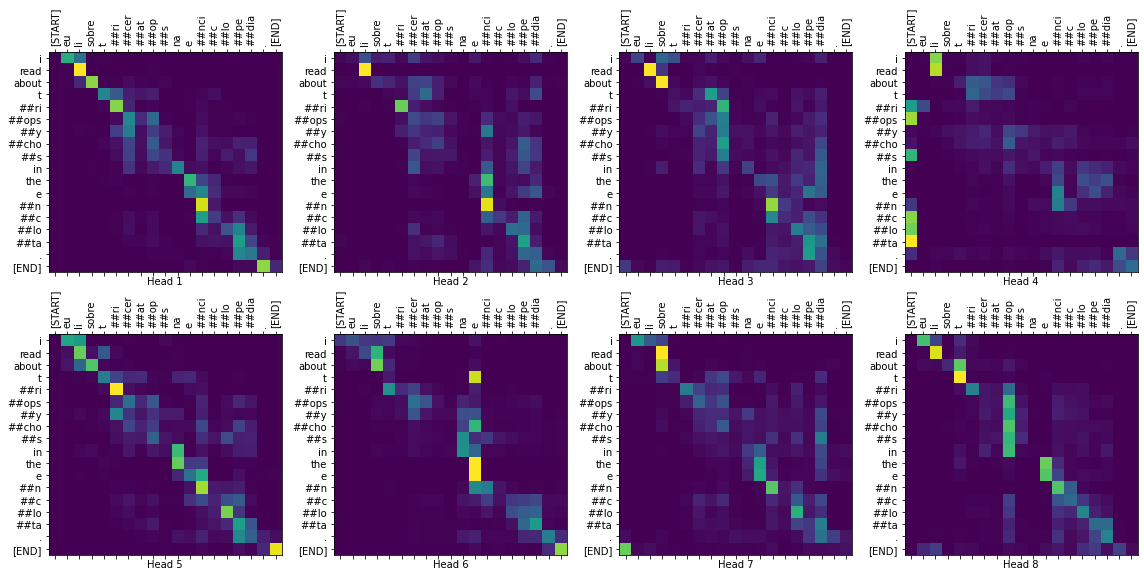

In [71]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [72]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [73]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [74]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [75]:
tf.saved_model.save(translator, export_dir='translator')

In [76]:
reloaded = tf.saved_model.load('translator')

In [77]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)t beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
